# CSE 204 Lab 12: Kernel methods

<img src="https://raw.githubusercontent.com/adimajo/polytechnique-cse204-2019-releases/master/logo.jpg" style="float: left; width: 15%" />

[CSE204-2019](https://moodle.polytechnique.fr/course/view.php?id=7862) Lab session #12

Jérémie Decock

## Introduction

In this lab, you will implement two kernel methods: Kernel k-Means and Kernel PCA.
While libraries such as scikit-learn provide facilities that implement these algorithms, they are simple enough for you to implement with numpy alone.
Before beginning, import the required packages.

**Note**
You might encounter problems rendering mathematical formulas in certain cells of the notebook (i.e. on certain cells it happens that mathematical formulas are replaced by their latex source code i.e. a latex code between dollar symbols).
It happens randomly (it happens sometimes and not always on the same formulas) and it usually happens when there are too many mathematical formulas to display.
We are looking for a solution to this problem but in the meantime, a workaround is to switch the edit / display mode on the affected cells to force Mathjax (the Javascript library used to render Latex formulas) to refresh the rendering of missing formulas.

In [77]:
colab_requirements = [
    "matplotlib>=3.1.2",
    "numpy>=1.18.1",
    "nose>=1.3.7",
]
import sys, subprocess
def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())
        
if "google.colab" in sys.modules:
    for i in colab_requirements:
        run_subprocess_command("pip install " + i)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
import numpy as np
import matplotlib.pyplot as plt
from random import randrange

## Part 1: Kernel methods

### Introduction

Some machine learning algorithms we have seen so far only work for "linear problems".

For instance:
- with linear regression (lab 2) we fit a hyperplane to predict unknown values, but the method can't effectively predict $f(\mathbf{x})$ if the (unknown) $f$ function is non-linear with respect to $\mathbf{x}$;
- with linear classification methods, the decision boundary is a hyperplane;
- the Principal Component Analysis (PCA) algorithm for feature extraction (lab 10) can only find "linear directions" in the data;
- in the k-means algorithm presented last week for clustering tasks, the separating boundary between clusters is linear (i.e. k-Means can only detect convex clusters).

As we have seen in lab 4, we can extend these methods to "nonlinear problems" applying a feature mapping $\phi$ on data.
This feature maps inputs data $\mathbf{x}_i \in \mathbb{R}^d$ into another space (the *feature space*) $\phi(\mathbf{x}_i) \in \mathbb{R}^{\hat{d}}$ where the "linear algorithm" is actually effective.
Here we note $I$ the input space and $F$ the feature space.

To be effective, the feature space is defined as a very high dimension space in many practical problems (usually $\hat{d} \gg d$).
Thus often, projections and computations in such a space are tedious and require a lot of computational power.

So here comes the *Kernel trick*.
The basic idea is to project data $\mathbf{x}_i$ in some high dimension feature space $F$ and apply an adapted version of the "linear algorithms" in this space without explicitly computing the projection $\phi(\mathbf{x}_i)$!
Using the kernel trick, we often don't even know what the feature map $\phi$ actually is!
Instead, computations are made implicitly from $I$ through a carefully chosen function $K: I \times I \rightarrow \mathbb{R}$ that compute some kind of similarity between two points of $I$.
This similarity function $K$ named *kernel* is chosen such that it represents a dot product in the high-dimensional feature space.

Thus, to be a valid kernel, $K$ have to be defined such that there is a $\phi$ function that holds: $K(\mathbf{x}_i, \mathbf{x}_j) = \phi(\mathbf{x}_i)^{\top} \phi(\mathbf{x}_j)$ for all $\mathbf{x}_i, \mathbf{x}_j \in I$.

The *Kernel matrix* $\mathbf{K}$ is a $n \times n$ matrix containing the pairwise similarity values between points in the dataset $\mathbf{D} \subset I$:
$$
\mathbf{K} =
\begin{pmatrix}
K(\mathbf{x}_1, \mathbf{x}_1) & K(\mathbf{x}_1, \mathbf{x}_2) & \cdots & K(\mathbf{x}_1, \mathbf{x}_n)\\
K(\mathbf{x}_2, \mathbf{x}_1) & K(\mathbf{x}_2, \mathbf{x}_2) & \cdots & K(\mathbf{x}_2, \mathbf{x}_n)\\
\vdots                        & \vdots                        & \ddots & \vdots\\
K(\mathbf{x}_n, \mathbf{x}_1) & K(\mathbf{x}_n, \mathbf{x}_2) & \cdots & K(\mathbf{x}_n, \mathbf{x}_n)
\end{pmatrix}
$$

Eventually, the kernel function $K$ allows us to compute a dot product in $F$ without explicitly constructing $\phi(\mathbf{x})$. The idea is then to find some machine learning algorithms that can be rewritten such that they only require the dot product $\phi(\mathbf{x}_i)^{\top} \phi(\mathbf{x}_j)$ in the feature space, i.e., algorithms where $\phi$ only appears in the form of a dot product $\phi(\mathbf{x}_i)^{\top} \phi(\mathbf{x}_j)$ (so that eventually all computation in $F$ can be performed exclusively over $K$).
PCA, k-Means and ridge regression are such compatible (*kernelizable*) algorithms.

We will now present some famous kernels. Let's start with the simplest one: the linear kernel.

#### The linear kernel

The linear kernel is defined as: $K(\mathbf{x}, \mathbf{y}) = \mathbf{x}^{\top} \mathbf{y}$
with $\mathbf{x}, \mathbf{y} \in I$.

Thus the feature mapping associated to this kernel is the identity mapping $\phi(\mathbf{x}) \mapsto \mathbf{x}$.

For instance, for two points $\mathbf{x} = \pmatrix{1 \\ 2}$ $\mathbf{y} = \pmatrix{3 \\ 1}$ in $\mathbf{D}$, we have:
$K(\mathbf{x}, \mathbf{y}) = 1 \times 3 + 2 \times 1 = 5$

**Note**: The linear kernel is not really the most useful in practice; "linear algorithms" won't work better on "nonlinear problems" using it. But it's a useful kernel to check some theoretical properties.

#### The polynomial kernel

The *inhomogeneous polynomial kernel* of degree $q$ is defined as: $K_q(\mathbf{x}, \mathbf{y}) = \left( c + \mathbf{x}^{\top} \mathbf{y} \right)^q$,
with $\mathbf{x}, \mathbf{y} \in I$ and some constant $c \geq 0$.
$K$ is an *homogeneous polynomial kernel* when $c=0$.

The feature mapping $\phi: \mathbb{R}^d \rightarrow \mathbb{R}^m$ associated to the polynomial kernel is:
$$
\phi(\mathbf{x}) = \pmatrix{\cdots & \sqrt{\pmatrix{q \\ \mathbf{n}} c^{n_0}} \displaystyle \prod_{k=1}^{d} x_k^{n_k} & \cdots} 
$$
where the variable $\mathbf{n} = (n_0, \dots, n_d)$ is the list $n_0, \dots, n_d$ of non-negative integers such that $\displaystyle \sum_{i=0}^d n_i = q$,
and where $\pmatrix{q \\ \mathbf{n}}$ denote the multinomial coefficient:

$$
\pmatrix{q \\ \mathbf{n}} = \pmatrix{q \\ n_0, n_1, \dots, n_d} = \frac{q!}{n_0! n_1! \dots n_d!}
$$

The dimensionality of the feature space is $m = \pmatrix{d + q \\ q}$.

For instance, for two points $\mathbf{x} = \pmatrix{1 \\ 2}$ $\mathbf{y} = \pmatrix{3 \\ 1}$ in $\mathbf{D}$ and for the *homogeneous quadratic kernel* ($q=2$ and $c=0$) we have:
$$K_2(\mathbf{x}, \mathbf{y}) = (1 \times 3 + 2 \times 1)^2 = 25$$

#### The Gaussian kernel

The Gaussian kernel is defined as:
$$
K(\mathbf{x}, \mathbf{y}) = \exp\left( \frac{- ||\mathbf{x} - \mathbf{y}||_2^2}{2 \sigma^2} \right)
$$

where $||\mathbf{x} - \mathbf{y}||_2^2$ is the Euclidean distance between $\mathbf{x}$ and $\mathbf{y}$
and where $\sigma > 0$ is a given "spread" parameter that plays the same role as the standard deviation in a normal density function.

Note that $K(\mathbf{x},\mathbf{x}) = 1$ and that the kernel value is inversely related to the distance between the two points $\mathbf{x}$ and $\mathbf{y}$.

The feature mapping $\phi: \mathbb{R}^d \rightarrow \mathbb{R}^{\infty}$ associated to the Gaussian kernel has infinite dimensions, thus we cannot explicitly transform $\mathbf{x}$ into $\phi(\mathbf{x})$.
However computing the Gaussian kernel $K(\mathbf{x},\mathbf{y})$ is straightforward.

For instance, for two points $\mathbf{x} = \pmatrix{1 \\ 2}$ $\mathbf{y} = \pmatrix{3 \\ 1}$ in $\mathbf{D}$ and the *Gaussian kernel* (with $\sigma=1$) we have:
$K(\mathbf{x}, \mathbf{y}) \approx 0.082$

### Exercise 1

Implement in Python the following kernel functions:
- Linear kernel
- Polynomial kernel
- Gaussian kernel 

In [79]:
def linear_kernel(x1, x2):
    """Linear Kernel
    
    Parameters:
    x1 (ndarray): a point of the input space (1D numpy array)
    x2 (ndarray): a point of the input space (1D numpy array)
    
    Return: k (float): the similarity K(x1, x2)"""
    k = np.dot(x1.T, x2)
    return k

def polynomial_kernel(x1, x2):
    """Polynomial Kernel
    
    Parameters
    x1 (ndarray): a point of the input space (1D numpy array)
    x2 (ndarray): a point of the input space (1D numpy array)

    Return: k (float): the similarity K(x1, x2)"""
    q = 2    # the degree of the polynomial kernel
    c = 0
    k = (c + np.dot(x1.T, x2))**q
    return k

def gaussian_kernel(x1, x2):
    """Gaussian Kernel
    
    Parameters:
    x1 (ndarray): a point of the input space (1D numpy array)
    x2 (ndarray): a point of the input space (1D numpy array)
    
    Return: k (float): the similarity K(x1, x2)"""
    sigma = 1
    k = np.exp(-np.linalg.norm(x1-x2)**2/(2*sigma**2))
    return k

x = np.array([1,2])
y = np.array([3,1])
print(linear_kernel(x,y), polynomial_kernel(x,y), gaussian_kernel(x,y))

5 25 0.08208499862389876


**Remark**: here parameters `q`, `c` and `sigma` are hard coded within the functions to simplify the implementation.
If you are confident enough with Python programming, you can implement the polynomial and the Gaussian kernel as [*functors*](https://en.wikipedia.org/wiki/Function_object#In_Python) (parametric functions i.e. classes with a defined `__call__` method).

### Exercise 2

Implement in Python the following function to make a kernel matrix from a given kernel function $K$ and a given dataset $\mathbf{D}$.

**Reminder**: in Python, a function is an object that can be passed as an argument to a function like any variable (cf. the implementation of `linear_kernel_matrix`, `polynomial_kernel_matrix` and `gaussian_kernel_matrix` hereafter).

In [80]:
def kernel_matrix(data, kernel_function):
    """Make a Kernel matrix.
    
    Parameters
    data (ndarray): the dataset (2D numpy array)
    kernel_function (function): the kernel function used to make the kernel matrix
    
    Return: K (ndarray): the n x n kernel matrix
    """
    K = np.array([np.array([kernel_function(i,j) for j in data]) for i in data])
    return K

In [81]:
# Following functions are provied here for convenience
def linear_kernel_matrix(data):
    return kernel_matrix(data, linear_kernel)

def polynomial_kernel_matrix(data):
    return kernel_matrix(data, polynomial_kernel)

def gaussian_kernel_matrix(data):
    return kernel_matrix(data, gaussian_kernel)

### Exercise 3: Basic kernel operations in feature space

In this exercise, we will look at some of the basic operations that can be preformed in the feature space solely via kernels (i.e. without computing $\phi(\mathbf{x})$).
These are the standard building blocks that are used to *kernelize* algorithms like k-Means, PCA, ...

#### Norm of a point

**Question 1:**
Show that we can compute the norm of a point $\phi(\mathbf{x})$ in the feature space as follows:
$$
\left\lVert \phi(\mathbf{x}) \right\rVert = \sqrt{K(\mathbf{x}, \mathbf{x})}
$$

#### Distance between points

**Question 2:**
Show that the distance between two points $\phi(\mathbf{x}_i)$ and $\phi(\mathbf{x}_j)$ in the feature space can be computed as:
$$
\left\lVert \phi(\mathbf{x}_i) - \phi(\mathbf{x}_j) \right\rVert = \sqrt{K(\mathbf{x}_i, \mathbf{x}_i) + K(\mathbf{x}_j, \mathbf{x}_j) - 2 K(\mathbf{x}_i, \mathbf{x}_j)}
$$

#### Mean in feature space

**Question 3:**
Show that the squared norm of the mean $\mathbf{\mu}_{\phi}$ in the feature space can be computed as:
$$
\left\lVert \mathbf{\mu}_{\phi} \right\rVert^2
= \mathbf{\mu}_{\phi}^{\top} \mathbf{\mu}_{\phi}
= \frac{1}{n^2} \sum_{i=1}^n \sum_{j=1}^n K(\mathbf{x}_i, \mathbf{x}_j)
$$

In other words, show that the squared norm of the mean in feature space is simply the average of the values in the kernel matrix $\mathbf{K}$.

#### Total variance in feature space


**Question 4:**
Show that the total variance $\sigma_{\phi}^2$ in the feature space can be computed as:
$$
\sigma_{\phi}^2
= \frac{1}{n} \sum_{i=1}^n \left\lVert \phi(\mathbf{x}_i) - \mathbf{\mu}_{\phi} \right\rVert^2
= \frac{1}{n} \sum_{i=1}^n K(\mathbf{x}_i, \mathbf{x}_i) - \frac{1}{n^2} \sum_{i=1}^n \sum_{j=1}^n K(\mathbf{x}_i, \mathbf{x}_j)
$$

In other words, show that the total variance in feature space is simply the difference between the average of the diagonal entries and the average of the entire kernel matrix $\mathbf{K}$.

#### Centering in feature space

We can center each point in the feature space by subtracting the mean from it: $\hat{\phi}(\mathbf{x}_i) = \phi(\mathbf{x}_i) - \mathbf{\mu}_{\phi}$.

Yet, we don't have an explicit representation of $\phi(\mathbf{x}_i)$ or $\mathbf{\mu}_{\phi}$
but we can still compute the *centered kernel matrix* $\hat{\mathbf{K}}$, that is the kernel matrix over centered points: $\hat{\mathbf{K}} = \left\{ \hat{K}(\mathbf{x}_i, \mathbf{x}_j) \right\}^n_{i,j=1}$ <br>
where each element corresponds to the kernel between centered points $\hat{K}(\mathbf{x}_i, \mathbf{x}_j) = \hat{\phi}(\mathbf{x}_i)^{\top} \hat{\phi}(\mathbf{x}_j)$.

**Question 5 (bonus):**
Show that:
$$
\hat{K}(\mathbf{x}_i, \mathbf{x}_j)
= K(\mathbf{x}_i, \mathbf{x}_j)
- \frac{1}{n} \sum_{k=1}^n K(\mathbf{x}_i, \mathbf{x}_k)
- \frac{1}{n} \sum_{k=1}^n K(\mathbf{x}_j, \mathbf{x}_k)
+ \frac{1}{n^2} \sum_{a=1}^n \sum_{b=1}^n K(\mathbf{x}_a, \mathbf{x}_b)
$$

**Note**: this can be rewritten as:
$$
\hat{\mathbf{K}}
= \left( \mathbf{I} - \frac{1}{n} \mathbf{1}_{n \times n} \right) \mathbf{K} \left( \mathbf{I} - \frac{1}{n} \mathbf{1}_{n \times n} \right)
$$
where $\mathbf{I}$ is the $n \times n$ identity matrix
and $\mathbf{1}_{n \times n}$ is the $n \times n$ matrix with all elements equal to 1.

#### Normalizing in feature space

One way to normalize points in a feature space is to ensure that they have a unit length by replacing $\phi(\mathbf{x}_i)$ with the corresponding unit vector $\phi_n(\mathbf{x}_i) = \frac{\phi(\mathbf{x}_i)}{\lVert \phi(\mathbf{x}_i) \rVert}$.

The dot product in a feature space corresponds to the cosine of the angle between the two mapped points because
$$
\phi_n(\mathbf{x}_i)^{\top} \phi_n(\mathbf{x}_j)
= \frac{\phi(\mathbf{x}_i)^{\top} \phi(\mathbf{x}_j)}{\lVert \phi(\mathbf{x}_i) \rVert \cdot \lVert \phi(\mathbf{x}_j) \rVert}
= \cos(\theta)
$$

If the mapped points are both centered and normalized, then a dot product corresponds to the correlation between the two points in the feature space.

The normalized kernel matrix $\mathbf{K}_n$ can be computed as:
$$
\mathbf{K}_n( \mathbf{x}_i, \mathbf{x}_j )
= \frac{\phi(\mathbf{x}_i)^{\top} \phi(\mathbf{x}_j)}{\lVert \phi(\mathbf{x}_i) \rVert \cdot \lVert \phi(\mathbf{x}_j) \rVert}
= \frac{K(\mathbf{x}_i, \mathbf{x}_j)}{\sqrt{K(\mathbf{x}_i, \mathbf{x}_i) \cdot K(\mathbf{x}_j, \mathbf{x}_j)}}
$$

$\mathbf{K}_n$ has diagonal elements equal to 1.

**Note**: this can be rewritten as:
$$
\mathbf{K}_n = \mathbf{W}^{-1/2} \cdot \mathbf{K} \cdot \mathbf{W}^{-1/2}
$$

with $\mathbf{W}^{-1/2}$ the diagonal matrix defined as
$$
\large
\mathbf{W}^{-1/2} =
\begin{pmatrix}
\frac{1}{\sqrt{K(\mathbf{x}_1, \mathbf{x}_1)}} & 0                                              & \cdots & 0\\
0                                              & \frac{1}{\sqrt{K(\mathbf{x}_2, \mathbf{x}_2)}} & \cdots & 0\\
\vdots                                         & \vdots                                         & \ddots & \vdots\\
0                                              & 0                                              & \cdots & \frac{1}{\sqrt{K(\mathbf{x}_n, \mathbf{x}_n)}}
\end{pmatrix}
$$

## Part 2: Clustering with the kernel k-means algorithm

### Introduction

We have studied the k-means algorithm for clustering tasks last week.
As this algorithm can easily be kernelized, we will use it to make a first implementation of a kernel method: Kernel k-Means.

In k-Means, the separating boundary between clusters is linear.
As we saw in the previous part, the most obvious advantage of applying the *kernel trick* to k-Means is that it allows us to extract nonlinear boundaries between clusters.
In other words, Kernel k-Means can detect nonconvex clusters.

You will see that this *Kernel k-Means* can be seen as an alternative to *Spectral Clustering*, the other clustering algorithm seen last week.

Once again, the main idea here is to conceptually map data points $\mathbf{x}$ in the input space to a point $\phi(\mathbf{x})$ in some high-dimensional feature space $F$ via an appropriate nonlinear mapping $\phi$.
The kernel trick allows us to carry out the clustering in feature space without explicitly making computations in this feature space.
All computation will be done in the input space $X$, using a kernel function $K(\mathbf{x}_i, \mathbf{x}_j)$ which will replace every dot (or inner) product $\phi(\mathbf{x}_i)^{\top} \phi(\mathbf{x}_j)$.
This means that we will have to rewrite the k-means algorithm such that the mapping function $\phi$ only appears in such dot products
$\phi(\mathbf{x}_i)^{\top} \phi(\mathbf{x}_j)$ (which in the end will be replaced by $K(\mathbf{x}_i, \mathbf{x}_j)$).

### Notation

We note $\mathbf{x} \in \mathbb{R}^d$ the point in the input space and
$\phi(\mathbf{x})$ its corresponding image in the feature space.
$D \subset \mathbb{R}^d$ is our dataset containing $n$ points.
We want to define $k$ clusters $C = \{C_1, \dots, C_k\}$, each one defining the cluster mean $\{\mathbf{\mu}^{\phi}_1, \dots, \mathbf{\mu}^{\phi}_k\}$ in the feature space:
$$
\mathbf{\mu}^{\phi}_i = \frac{1}{n_i} \sum_{\mathbf{x}_j \in C_i} \phi(\mathbf{x}_j)
$$
where $\mu^{\phi}_i$ is the mean of the i-th cluster $C_i$ in feature space,
with $n_i = |C_i|$.

### Step 1: express the k-means *sum of squared errors* (SSE) objective function in terms of the kernel function

The kernel k-means sum of squared errors (SSE) objective can be written as
$$
SSE(C) = \sum_{i=1}^k\sum_{\mathbf{x}_j \in C_i} \left\lVert \phi(\mathbf{x}_j) - \mathbf{\mu}^{\phi}_i \right\rVert^2
$$

**Question 1**: show that $SSE(C)$ can be rewritten as:
$$
SSE(C) =
\left( \sum_{i=1}^k\sum_{\mathbf{x}_j \in C_i} \phi(\mathbf{x}_j)^{\top} \phi(\mathbf{x}_j) \right)
- \left( \sum_{i=1}^k n_i \left\lVert \mathbf{\mu}^{\phi}_i \right\rVert^2 \right)
$$

**Question 2**: show then - using kernel operations seen in Part 1 - that $SSE(C)$ can be rewritten as:
$$
SSE(C) =
\sum_{j=1}^n K(\mathbf{x}_j, \mathbf{x}_j)
- \sum_{i=1}^k \frac{1}{n_i}
  \sum_{\mathbf{x}_a \in C_i}
  \sum_{\mathbf{x}_b \in C_i} K(\mathbf{x}_a, \mathbf{x}_b)
$$

As for k-Means, in Kernel k-Means, we assign each point to the closest mean in feature space, resulting in a new clustering, which in turn can be used to obtain new estimates for the cluster means.
The main difficulty is that we cannot explicitly compute the mean of clusters in feature space.
Fortunately, we will see that knowing explicitly the mean of clusters is not required for the clustering task.

### Step 2: express the distance of a point $\phi(\mathbf{x}_j)$ to the mean $\mathbf{\mu}^{\phi}_i$

**Question 3**: show that
$$
\left\lVert \phi(\mathbf{x}_j) - \mathbf{\mu}^{\phi}_i \right\rVert^2
=
K(\mathbf{x}_j, \mathbf{x}_j)
- \frac{2}{n_i} \sum_{\mathbf{x}_a \in C_i} K(\mathbf{x}_a, \mathbf{x}_j)
+ \frac{1}{n^2_i} \sum_{\mathbf{x}_a \in C_i}\sum_{\mathbf{x}_b \in C_i} K(\mathbf{x}_a, \mathbf{x}_b)
$$

Thanks to this equation, the distance of a point to a cluster mean in feature space can be computed using only kernel operations.

### Step 3: define the cluster assignment

**Question 4**: show that the cluster assignment used at each iteration of the k-means algorithm can be written as follow
$$
C^*(\mathbf{x}_j) =
\arg\min_i \left\{
\frac{1}{n^2_i} \sum_{\mathbf{x}_a \in C_i}\sum_{\mathbf{x}_b \in C_i} K(\mathbf{x}_a, \mathbf{x}_b)
- \frac{2}{n_i} \sum_{\mathbf{x}_a \in C_i} K(\mathbf{x}_a, \mathbf{x}_j)
\right\}
$$

Note that the first term in the argmin is the average pairwise kernel value for cluster $C_i$ and it is independent of the point $\mathbf{x}_j$.
It is the squared norm of the cluster mean in feature space.

The second term is twice the average kernel value for points in $C_i$ with respect to $\mathbf{x}_j$.

### Step 4: implement Kernel K-means algorithm

**Question 5**: implement in Python Kernel K-means defined below.

___
### Algorithm 1

Kernel K-means$(\mathbf{K}, k, \epsilon)$

$t \leftarrow 0$ <br>
$C \leftarrow \{C_1, \dots, C_k\} \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad$ # Randomly partition points into $k$ clusters <br>

**REPEAT**

$\quad t \leftarrow t+1$ <br>

$\quad$**FOREACH** $C_i \in C^{t-1}$ <br>
$\quad\quad$$\text{sqnorm}_i \leftarrow \displaystyle \frac{1}{n^2_i} \sum_{\mathbf{x}_a \in C_i}\sum_{\mathbf{x}_b \in C_i} K(\mathbf{x}_a, \mathbf{x}_b) \quad\quad\quad$ # Compute the squared norm of cluster means <br>

$\quad$**FOREACH** $\mathbf{x}_j \in D$ <br>
$\quad\quad$**FOREACH** $C_i \in C^{t-1}$ <br>
$\quad\quad\quad$$\text{avg}_{ji} \leftarrow \displaystyle \frac{1}{n_i} 
 \sum_{\mathbf{x}_a \in C_i} K(\mathbf{x}_a, \mathbf{x}_j) \quad\quad\quad\quad\quad\quad$ # Average kernel value for $\mathbf{x}_j$ and $C_i$ <br>

$\quad$# Find the closest cluster for each point <br>
$\quad$**FOREACH** $\mathbf{x}_j \in D$ <br>
$\quad\quad$**FOREACH** $C_i \in C^{t-1}$ <br>
$\quad\quad\quad$$d(\mathbf{x}_j, C_i) \leftarrow \text{sqnorm}_i - 2 ~ \text{avg}_{ji}$ <br>
$\quad\quad$$j^* \leftarrow \arg\min_i \left\{ d(\mathbf{x}_j, C_i) \right\}$ <br>
$\quad\quad$$C^t_{j^*} \leftarrow C^t_{j^*} \cup \{ \mathbf{x}_j \} \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad$ # Cluster reassignment <br>

$\quad$$C^t \leftarrow \{C_1^t, \dots, C_k^t\}$ <br>

**UNTIL** the fraction of points with new cluster assignments $\leq \epsilon$
___


In [91]:
def kernel_k_means(K, k, epsilon = 0.1):
    """Kernel K-means
    
    Parameters
    K (ndarray): the n-by-n Kernel matrix of inputs
    k (int): the number of clusters to find
    epsilon (float): the termination criterion
    
    Return
    label (ndarray): a 1D vector of labels of length n (e.g. label[i] = C_j means "x_i is belongs to cluster C_j")
    """
    N = K.shape[0]
    label = np.random.randint(k, size=N)    # randomly partition
    while True:
        sqnorm = np.zeros(k)
        for i in range(k):
            ki = K[label == i, :][:, label == i]
            sqnorm[i] = np.sum(ki) / (ki.shape[0] ** 2)

        avg = np.zeros((N, k))
        for j in range(N):
            for i in range(k):
                ki = K[label == i, :]
                avg[j][i] = np.sum(ki[:,j]) / ki.shape[0]

        d = np.zeros((N, k))
        newlabel = np.zeros(N)
        for j in range(N):
            for i in range(k):
                d[j][i] = sqnorm[i] - 2 * avg[j][i]
            minj = np.argmin(d[j, :])
            newlabel[j] = minj
        samelabel = (label == newlabel).sum()
        if 1 - samelabel/N <= epsilon:
            break
        label = newlabel
    return label

### Step 5: Test the implementation on a set of given datasets

We will use the same datasets than last week:
- the first dataset consists of 4 gaussian-distributed clusters of points with equal variance;
- the second represents two clusters, one stretched vertically, and one horizontally;
- finally, the last dataset represents 3 clusters distributed in rings.

For convenience, the three datasets are placed in a list called `datasets`.

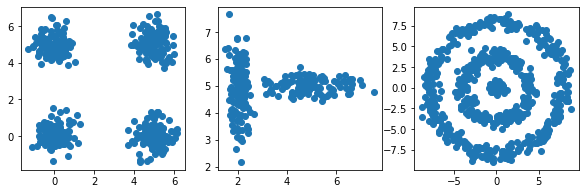

In [92]:
# Create a data set
N = 120

data1 = np.random.normal((0,0), (0.5,0.5) ,size=(N,2))
data1 = np.append(data1, np.random.normal((5,0), (0.5,0.5), size=(N,2)), axis=0)
data1 = np.append(data1, np.random.normal((0,5), (0.5,0.5), size=(N,2)), axis=0)
data1 = np.append(data1, np.random.normal((5,5), (0.5,0.5), size=(N,2)), axis=0)

data2 = np.random.normal((2,5), (0.25, 1), size=(N,2))
data2 = np.append(data2, np.random.normal((5,5), (1, 0.25), size=(N,2)), axis=0)

radii = np.random.normal(0,0.5,size=(N,1))
radii = np.append(radii, np.random.normal(4,0.5,size=(2*N,1)), axis=0)
radii = np.append(radii, np.random.normal(8,0.5,size=(3*N,1)), axis=0)
angles = np.random.uniform(size=(6*N,1))*2.0*np.pi
data3 = np.hstack([radii*np.cos(angles), radii*np.sin(angles)])

datasets = [data1, data2, data3]

fig, axes = plt.subplots(1,len(datasets), figsize=(10,3))
for i,data in enumerate(datasets):
    axes[i].scatter(data[:,0], data[:,1])

To test your implementation, run the following code which will plot the 3 datasets, trying different values of $k$.

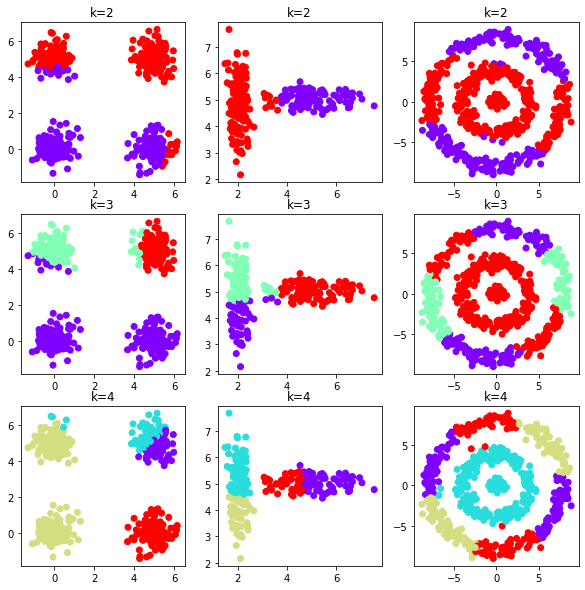

In [96]:
fig, axes = plt.subplots(3, len(datasets), figsize=(10,10))

for k_index, k in enumerate([2, 3, 4]):
    for dataset_index, data in enumerate(datasets):
        Matrix = polynomial_kernel_matrix(data)
        labels = kernel_k_means(Matrix, k)
        axes[k_index, dataset_index].scatter(data[:,0], data[:,1], c=labels, cmap='rainbow')
        axes[k_index, dataset_index].set_title('k=' + str(k))

## Part 3: Feature extraction with the Kernel PCA algorithm (Bonus)

We have studied the Principal Component Analysis (PCA) algorithm for features extraction tasks in lab 10.
PCA can be "kernelized" to find nonlinear "directions" in the data.

Kernel PCA finds the directions of most variance in feature space instead of the input space.

Again, using the *kernel trick*, all operations can be carried out in terms of the kernel function in input space, without having to transform the data into feature space.

We won't detail the kernelization process here but instead we will focus on the implementation and the obtained results.

As a reminder, the PCA algorithm is described in algorithm 2 defined below. Its kernelized version is defined in algorithm 3.

___
### Algorithm 2

PCA$(\mathbf{D}, r)$
$$
\begin{array}{lrcl}
{\tiny 1.} \quad\quad & \mathbf{\mu}    & = & \frac{1}{n} \sum_{i=1}^{n} \mathbf{x}_i                                          & \text{# Compute the mean} \\
{\tiny 2.}            & \mathbf{Z}      & = & \mathbf{D} - \mathbf{1} \cdot \mathbf{\mu}^{\top}                                & \text{# Center the dataset } \mathbf{D} \text{ (c.f. note below)} \\
{\tiny 3.}            & \mathbf{\Sigma} & = & \frac{1}{n} \left( \mathbf{Z}^{\top} \mathbf{Z} \right)                          & \text{# Compute the covariance matrix} \\
{\tiny 4.}            & (\lambda_1, \lambda_2, \dots, \lambda_d)                         & = & \text{eigenvalues}(\mathbf{\Sigma})  & \text{# Compute eigenvalues} \\
{\tiny 5.}            & \mathbf{U}   = \pmatrix{ \mathbf{u}_1 & \mathbf{u}_2 & \dots & \mathbf{u}_d } & = & \text{eigenvectors}(\mathbf{\Sigma}) & \text{# Compute eigenvectors} \\
{\tiny 6.}            & \mathbf{U}_r & = & \pmatrix{\mathbf{u}_1 & \mathbf{u}_2 & \dots & \mathbf{u}_r}                                   & \text{# Reduced basis} \\
{\tiny 7.}            & \mathbf{A}   & = & \left\{\mathbf{a}_i | \mathbf{a}_i = \mathbf{U}_r^{\top}\mathbf{x}_i ~ \text{ for } i = 1, \dots, n \right\} \quad  & \text{# Projected data} \\
\end{array}
$$

___


Here, $\mathbf{D}$ is the $n \times d$ dataset matrix ($n$ points of $d$ dimensions) and $r$ is the size of the basis we want to compute.

$\mathbf{1}$ is the $n \times d$ matrix all of whose elements are 1 ([numpy.ones(shape=(n, d))](https://numpy.org/doc/stable/reference/generated/numpy.ones.html?highlight=ones#numpy.ones) in Python).

**Note:** The $\mathbf{1} \cdot \mathbf{\mu}^{\top}$ matrix can be made with [np.tile(mu, (d, 1))](https://numpy.org/doc/stable/reference/generated/numpy.tile.html?highlight=tiles) in Python (assuming mu is a 1D numpy array).

**Question 1**: implement in Python the Kernel PCA algorithm defined below.

___
### Algorithm 3

Kernel PCA$(\mathbf{D}, K, r)$

$$
\begin{array}{lrcl}
{\tiny 1.} \quad\quad & \mathbf{K}   & = & \{ K(\mathbf{x}_i, \mathbf{x}_j) \}_{i,j=1, \dots, n}                                                              & \text{# Compute the } n \times n \text{ kernel matrix from the dataset } \mathbf{D} \\
{\tiny 2.}            & \mathbf{K}   & = & (\mathbf{I} - \frac{1}{n}\mathbf{1}_{n \times n}) ~ \mathbf{K} ~ (\mathbf{I} - \frac{1}{n}\mathbf{1}_{n \times n}) & \text{# Center the kernel matrix (c.f. Part 1)} \\
{\tiny 3.}            & (\eta_1, \eta_2, \dots, \eta_d)                   & = & \text{eigenvalues}(\mathbf{K})                                                & \text{# Compute eigenvalues} \\
{\tiny 4.}            & \pmatrix{ \mathbf{c}_1 & \mathbf{c}_2 & \dots & \mathbf{c}_n } & = & \text{eigenvectors}(\mathbf{K})                                               & \text{# Compute eigenvectors} \\
{\tiny 5.}            & \mathbf{C}_r & = & \pmatrix{ \mathbf{c}_1 & \mathbf{c}_2 & \dots & \mathbf{c}_r }                                                                  & \text{# Reduce basis} \\
{\tiny 6.}            & \mathbf{A}   & = & \left\{ \mathbf{a}_i | \mathbf{a}_i = \mathbf{C}_r^{\top}\mathbf{K}_i ~ \text{ for } i = 1, \dots, n \right\}  \quad             & \text{# Reduced dimensionality data} \\
\end{array}
$$

___


Here, $\mathbf{D}$ is the $n \times d$ dataset matrix ($n$ points of $d$ dimensions), $K$ is a kernel function and $r$ is the size of the basis we want to compute.

$\mathbf{I}$ is the $n \times n$ identity matrix
and $\mathbf{1}_{n \times n}$ is the $n \times n$ matrix all of whose elements are 1 ([numpy.ones(shape=(n, n))](https://numpy.org/doc/stable/reference/generated/numpy.ones.html?highlight=ones#numpy.ones) in Python).

**Note**: Eigen vectors and eigen values can be computed with [numpy.linalg.eig(K)](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html#numpy.linalg.eig).

In [ ]:
def kernel_pca(data, kernel, r):
    """Kernel PCA
    
    Parameters
    ----------
    data : ndarray
        the dataset used to make the kernel matrix of inputs
    kernel : function
        the kernel function used to make the kernel matrix of inputs
    r : int
        the number of principal components to use
    
    Return
    ------
    projected_data : ndarray
        the dataset projected on the r principal components
    """

    # TODO...

    return projected_data

**Question 2**: test the implementation on the following dataset (using the quadratic kernel defined in Part 1).

In [ ]:
data = np.random.multivariate_normal(mean=np.zeros(2), cov=np.array([[1, 0], [0, 1]]), size=100)
data[:,0] = 0.2 * data[:,0]**2 + data[:,1]**2 + 0.1 * data[:,0] * data[:,1]
plt.scatter(data[:,0], data[:,1]);

In [ ]:
projected_data = kernel_pca(data, quadratic_kernel_function, 2)

plt.plot(projected_data)
plt.show();

## Part 4: Kernel Ridge Regression (Bonus)

**Question 1**: implement in Python the Kernel Ridge Regression algorithm defined in [lecture notes](https://moodle.polytechnique.fr/pluginfile.php/203685/mod_resource/content/1/Notes_12.pdf).

In [ ]:
def kernel_ridge_regression(x, dataset, kernel_matrix):
    """Kernel ridge regression
    
    Parameters
    ----------
    x : float
        the value to predict
    dataset : ndarray
        the dataset used to make the kernel matrix of inputs
    kernel : function
        the kernel function used to make the kernel matrix of inputs
    
    Return
    ------
    y_pred : float
        the predicted value for x
    """

    # TODO...

    return y_pred

**Question 2**: test the implementation on the following non linear 1D dataset used in lab 4.

In [ ]:
dataset = pd.DataFrame([[2., 0.],
                        [5., 2.],
                        [7., 1.],
                        [10., 2.],
                        [14., 4.],
                        [16., 3.],
                        [17., 0.]], columns=['x', 'y'])
dataset

In [ ]:
kernel_matrix = ... # TODO

In [ ]:
x_pred = np.linspace(0., 20., 200)
y_pred = [kernel_ridge_regression(x, dataset, kernel_matrix) for x in x_pred]

ax = dataset.plot.scatter(x='x', y='y', label="Dataset", figsize=(12,8))
ax.plot(x_pred, y_pred, "-r", label="Kernel ridge regression")
plt.legend();